In [897]:
import pandas as pd
from bs4 import BeautifulSoup
import time
import requests
import re
import glob
from pandas.errors import EmptyDataError
from datetime import datetime

In [898]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [899]:
%%javascript
// Disable auto-scrolling
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Scrape "ice in" and "ice out" dates from Minnesota Department of Natural Resource.

In [900]:
# for lake_id in ids:
#     ice_in_url = f"https://maps1.dnr.state.mn.us/cgi-bin/climatology/ice_in_by_lake_as_csv.cgi?id={lake_id}"
#     response = requests.get(ice_in_url)
#     with open(f"data/ice_in/ice_in_{lake_id}.csv", "wb") as f:
#         f.write(response.content)
#     time.sleep(3)

In [901]:
# for lake_id in ids:
#     ice_out_url = f"https://maps1.dnr.state.mn.us/cgi-bin/climatology/ice_out_by_lake_as_csv.cgi?id={lake_id}"
#     response = requests.get(ice_out_url)
#     with open(f"data/ice_out/ice_out_{lake_id}.csv", "wb") as f:
#         f.write(response.content)
#     time.sleep(3)

## Build dataframe of lake names and IDs from website HTMLL

In [902]:
with open('lake_id.txt', "r") as file:
    raw_ids = file.read().strip()

In [903]:
name_and_id = re.findall(r'">([^<]*)</option', raw_ids)
name_and_id = name_and_id[1:]

In [904]:
lakes = {}

for lake in name_and_id:
    lake_id = lake.split(" - ")[1]
    lake_name = lake.split(" - ")[0]
    lakes[lake_id] = lake_name

In [905]:
lake_profiles = pd.DataFrame([lakes]).transpose().reset_index()
lake_profiles.columns = ['lake_id', 'lake_name']

## Analyze ice coverage data

#### Import and clean "ice in" dates

In [906]:
# Use glob to find all CSV files in the folder
ice_in = glob.glob("ice_in/*.csv")

# Create an empty DataFrame to store the concatenated data
df_in = pd.DataFrame()

# Loop over each CSV file and append it to the DataFrame
for f in ice_in:
    ice_in_data = pd.read_csv(f, header=2)
    id_from_file = f[-12:-4]
    ice_in_data["ID"] = id_from_file
    df_in = pd.concat([df_in, ice_in_data])

#### Import and clean "ice out" dates

In [907]:
# Use glob to find all CSV files in the folder
ice_out = glob.glob("ice_out/*.csv")

# Create an empty DataFrame to store the concatenated data
df_out = pd.DataFrame()

# Loop over each CSV file and appenfor f in ice_out:
for f in ice_out:
    try:
        ice_out_data = pd.read_csv(f, skiprows=2)
        id_from_file = f[-12:-4]
        ice_out_data["ID"] = id_from_file
        df_out = pd.concat([df_out, ice_out_data])
    except EmptyDataError:
        pass

#### Merge ice in and out data. Calculate ice days.

In [908]:
df_in.drop('Source', axis=1, inplace=True)
df_out.drop('Source', axis=1, inplace=True)

In [909]:
df = pd.merge(df_in, df_out, how="inner", on="ID")
df.columns = ['ice_in_date', 'lake_id', 'ice_out_date']
df = df[['lake_id', 'ice_in_date', 'ice_out_date']]

In [910]:
df.ice_in_date = pd.to_datetime(df.ice_in_date)
df.ice_out_date = pd.to_datetime(df.ice_out_date)

In [911]:
df['ice_days'] = df.ice_out_date - df.ice_in_date
df['ice_days'] = df['ice_days'].dt.days

In [912]:
df = df[(df.ice_days > 0) & (df.ice_days < 200)]

#### Merge lake id and lake name.

In [913]:
df = df.merge(lake_profiles, on="lake_id")

In [914]:
count = df.groupby('lake_id')['ice_days'].count().sort_values(ascending=False).reset_index()
count.columns = ['lake_id', 'measured_years']

In [915]:
df_with_measured_years = df.merge(count, on="lake_id")
df = df_with_measured_years

In [916]:
df['decade'] = (df.ice_in_date.dt.year//10)*10
df['decade'] = df['decade'].astype(str)
df['year'] = df.ice_in_date.dt.year
df['year'] = df['year'].astype(str)
df['ice_in_month'] = df.ice_in_date.dt.month
df['ice_out_month'] = df.ice_out_date.dt.month
df['ice_in_month_date'] = df.ice_in_date.dt.month.astype(str)+'-'+df.ice_in_date.dt.day.astype(str)
df['ice_out_month_date'] = df.ice_out_date.dt.month.astype(str)+'-'+df.ice_out_date.dt.day.astype(str)

In [917]:
df['ice_in_month_datetime'] = pd.to_datetime(df['ice_in_month_date'], format='%m-%d')
df['ice_in_month_day_dt'] = df['ice_in_month_datetime'].dt.strftime('%m-%d')

df['ice_out_month_datetime'] = pd.to_datetime(df['ice_out_month_date'], format='%m-%d')
df['ice_out_month_day_dt'] = df['ice_out_month_datetime'].dt.strftime('%m-%d')

# df.drop(['ice_in_month_datetime', 'ice_out_month_datetime', 'ice_in_month_date', 'ice_out_month_date'], axis=1, inplace=True)

In [976]:
df

,lake_id,ice_in_date,ice_out_date,ice_days,lake_name,measured_years,decade,year,ice_in_month,ice_out_month,ice_in_month_date,ice_out_month_date,ice_in_month_datetime,ice_in_month_day_dt,ice_out_month_datetime,ice_out_month_day_dt
0,82001000,1992-11-14,1993-04-12,149,McDonald,35,1990,1992,11,4,11-14,4-12,1900-11-14,11-14,1900-04-12,04-12
1,82001000,1993-11-25,1994-04-01,127,McDonald,35,1990,1993,11,4,11-25,4-1,1900-11-25,11-25,1900-04-01,04-01
2,82001000,1994-11-25,1995-04-15,141,McDonald,35,1990,1994,11,4,11-25,4-15,1900-11-25,11-25,1900-04-15,04-15
3,82001000,1995-11-09,1996-04-19,162,McDonald,35,1990,1995,11,4,11-9,4-19,1900-11-09,11-09,1900-04-19,04-19
4,82001000,1996-11-12,1997-04-11,150,McDonald,35,1990,1996,11,4,11-12,4-11,1900-11-12,11-12,1900-04-11,04-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4917,29061000,2019-11-07,2020-04-27,172,Arco,4,2010,2019,11,4,11-7,4-27,1900-11-07,11-07,1900-04-27,04-27
4918,66003900,2007-12-01,2008-04-20,141,Mazaska,5,2000,2007,12,4,12-1,4-20,1900-12-01,12-01,1900-04-20,04-20
4919,66003900,2017-12-07,2018-04-30,144,Mazaska,5,2010,2017,12,4,12-7,4-30,1900-12-07,12-07,1900-04-30,04-30
4921,66003900,2019-12-02,2020-03-30,119,Mazaska,5,2010,2019,12,3,12-2,3-30,1900-12-02,12-02,1900-03-30,03-30


In [975]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3468 entries, 0 to 4922
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   lake_id                 3468 non-null   object        
 1   ice_in_date             3468 non-null   datetime64[ns]
 2   ice_out_date            3468 non-null   datetime64[ns]
 3   ice_days                3468 non-null   int64         
 4   lake_name               3468 non-null   object        
 5   measured_years          3468 non-null   int64         
 6   decade                  3468 non-null   object        
 7   year                    3468 non-null   object        
 8   ice_in_month            3468 non-null   int64         
 9   ice_out_month           3468 non-null   int64         
 10  ice_in_month_date       3468 non-null   object        
 11  ice_out_month_date      3468 non-null   object        
 12  ice_in_month_datetime   3468 non-null   datetime

In [918]:
df.drop_duplicates(inplace=True)

In [919]:
df

,lake_id,ice_in_date,ice_out_date,ice_days,lake_name,measured_years,decade,year,ice_in_month,ice_out_month,ice_in_month_date,ice_out_month_date,ice_in_month_datetime,ice_in_month_day_dt,ice_out_month_datetime,ice_out_month_day_dt
0,82001000,1992-11-14,1993-04-12,149,McDonald,35,1990,1992,11,4,11-14,4-12,1900-11-14,11-14,1900-04-12,04-12
1,82001000,1993-11-25,1994-04-01,127,McDonald,35,1990,1993,11,4,11-25,4-1,1900-11-25,11-25,1900-04-01,04-01
2,82001000,1994-11-25,1995-04-15,141,McDonald,35,1990,1994,11,4,11-25,4-15,1900-11-25,11-25,1900-04-15,04-15
3,82001000,1995-11-09,1996-04-19,162,McDonald,35,1990,1995,11,4,11-9,4-19,1900-11-09,11-09,1900-04-19,04-19
4,82001000,1996-11-12,1997-04-11,150,McDonald,35,1990,1996,11,4,11-12,4-11,1900-11-12,11-12,1900-04-11,04-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4917,29061000,2019-11-07,2020-04-27,172,Arco,4,2010,2019,11,4,11-7,4-27,1900-11-07,11-07,1900-04-27,04-27
4918,66003900,2007-12-01,2008-04-20,141,Mazaska,5,2000,2007,12,4,12-1,4-20,1900-12-01,12-01,1900-04-20,04-20
4919,66003900,2017-12-07,2018-04-30,144,Mazaska,5,2010,2017,12,4,12-7,4-30,1900-12-07,12-07,1900-04-30,04-30
4921,66003900,2019-12-02,2020-03-30,119,Mazaska,5,2010,2019,12,3,12-2,3-30,1900-12-02,12-02,1900-03-30,03-30


In [920]:
# Exclude lakes with 7 or fewer observations

df = df[~df.measured_years<8]

In [921]:
yearly_df = pd.DataFrame(df.groupby('year')['ice_days'].mean())
yearly_df['num_lakes'] = df.groupby('year')['lake_id'].count()

yearly_df.reset_index(inplace=True)

In [922]:
# min_samplesize = 10

# yearly_min_sample_df =  yearly_df[yearly_df.num_lakes >= min_samplesize]

# sample_years = ['1960', '1965', '1970', '1975', '1980', '1985', '1990', '1995','2000', '2005','2010', '2015','2020']
# sample_years_df = df[df.year.astype(str).isin(sample_years)]
# sample_years_df.year = sample_years_df.year.astype(str)

<AxesSubplot: xlabel='year'>

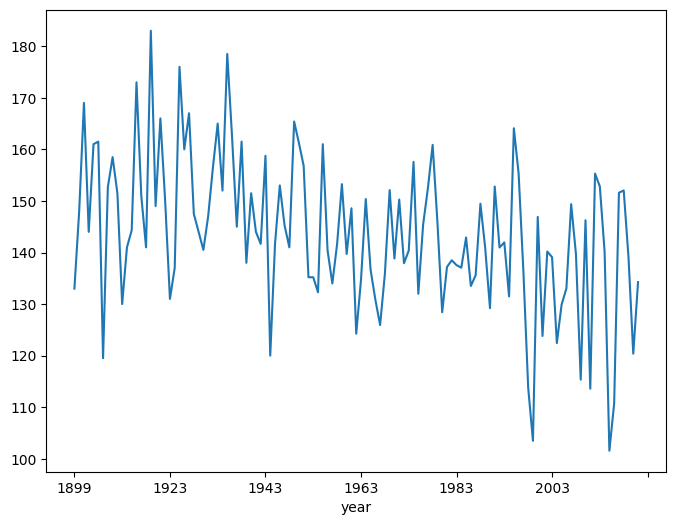

In [923]:
plt.figure(figsize=(8, 6))

df.groupby('year').ice_days.mean().plot()

### Build graphs using ggplot

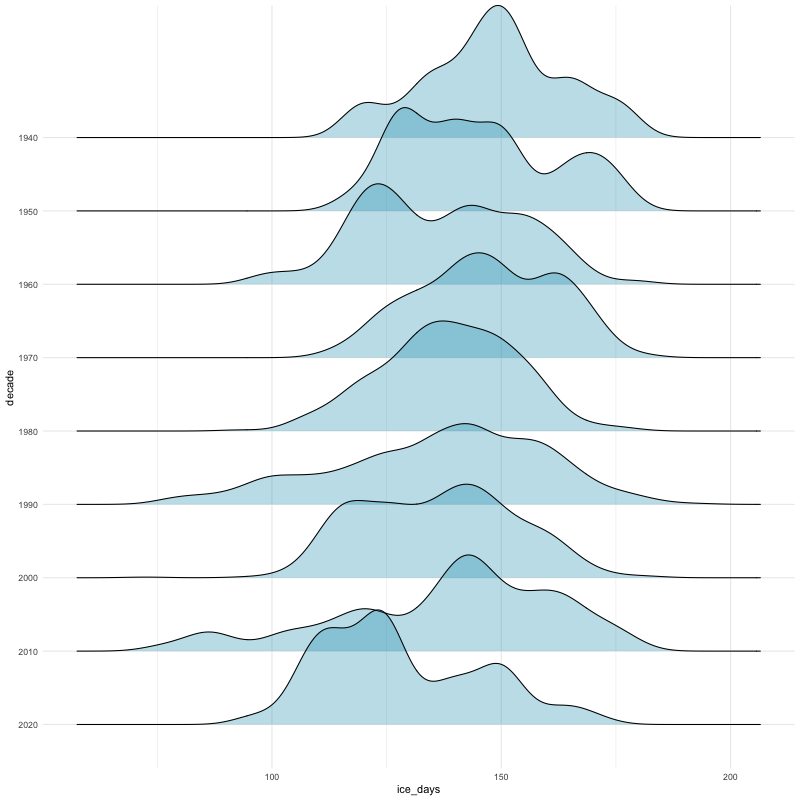

In [924]:
%%R -i df -w 800 -h 800

# df <- df %>% filter(df$decade >1930)

# Average plot per decade.
ggplot(df %>% filter(df$decade >1930), aes(x = ice_days, y = decade)) +
    geom_density_ridges(alpha=0.3, bandwidth=4.5, fill="#0D98BA") + 
    scale_fill_viridis(discrete=TRUE) +
    scale_color_viridis(discrete=TRUE) +
    theme_minimal() + 
    coord_cartesian(clip = "off") +
    scale_y_discrete(limits=rev)
 
# ggsave("iceridge.pdf")

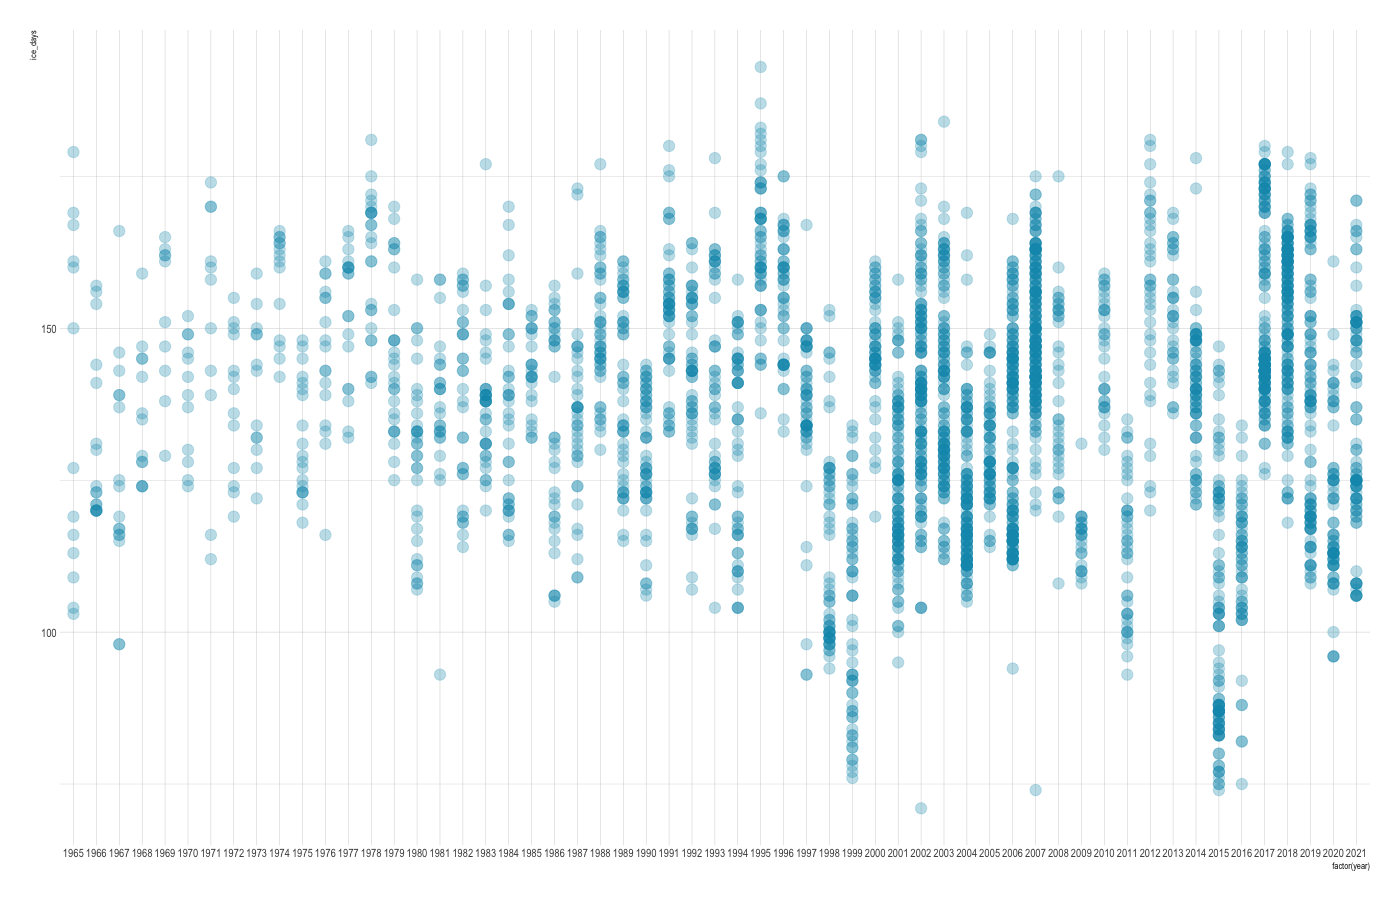

In [925]:
%%R -i df -w 1400 -h 900

df <- df %>% filter(df$year >1964)

ggplot(df, aes(x = ice_days, y = factor(year))) +
  geom_point(size=5, alpha = 0.3, position = position_dodge(width = 0.5), color='#0D98BA') + 
  scale_color_viridis(discrete = TRUE) +
  theme_ipsum() +
  theme(
    legend.position = "none",
    panel.spacing = unit(0.1, "lines"),
    strip.text.x = element_text(size = 8)
  ) +
  coord_flip()


## Analyze specific lakes

### Only look into lakes with at lease 50 years of observed data

In [926]:
df_50plus = df[df.measured_years>=50]

In [927]:
df_50plus.lake_name.unique()

array(['Little Rock', 'Bemidji', 'Eighth Crow Wing', 'George',
       'Farm Island', 'Wabana', 'Green', 'Burntside', 'Portage',
       'Kabekona', 'Washington', 'Lake of the Isles', 'Little McDonald',
       'Long', 'Shagawa', 'Upper Prior', 'Detroit', 'Harriet',
       'Floyd (south bay)', 'Minnetonka', 'Turtle', 'Wirth', 'Itasca',
       'Bde Maka Ska', 'Pelican', 'Waconia', 'Bad Medicine'], dtype=object)

In [928]:
bemidji = df.query("lake_name=='Bemidji'")

In [929]:
bemidji.drop_duplicates()

,lake_id,ice_in_date,ice_out_date,ice_days,lake_name,measured_years,decade,year,ice_in_month,ice_out_month,ice_in_month_date,ice_out_month_date,ice_in_month_datetime,ice_in_month_day_dt,ice_out_month_datetime,ice_out_month_day_dt
171,04013000,1958-11-12,1959-04-25,164,Bemidji,125,1950,1958,11,4,11-12,4-25,1900-11-12,11-12,1900-04-25,04-25
172,04013000,1959-11-14,1960-04-24,162,Bemidji,125,1950,1959,11,4,11-14,4-24,1900-11-14,11-14,1900-04-24,04-24
173,04013000,1960-11-20,1961-04-29,160,Bemidji,125,1960,1960,11,4,11-20,4-29,1900-11-20,11-20,1900-04-29,04-29
174,04013000,1961-11-26,1962-05-02,157,Bemidji,125,1960,1961,11,5,11-26,5-2,1900-11-26,11-26,1900-05-02,05-02
175,04013000,1962-12-02,1963-04-17,136,Bemidji,125,1960,1962,12,4,12-2,4-17,1900-12-02,12-02,1900-04-17,04-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,04013000,2018-11-20,2019-04-28,159,Bemidji,125,2010,2018,11,4,11-20,4-28,1900-11-20,11-20,1900-04-28,04-28
292,04013000,2018-11-20,2019-04-30,161,Bemidji,125,2010,2018,11,4,11-20,4-30,1900-11-20,11-20,1900-04-30,04-30
293,04013000,2019-12-03,2020-04-29,148,Bemidji,125,2010,2019,12,4,12-3,4-29,1900-12-03,12-03,1900-04-29,04-29
294,04013000,2020-11-30,2021-04-06,127,Bemidji,125,2020,2020,11,4,11-30,4-6,1900-11-30,11-30,1900-04-06,04-06


In [931]:
bemidji.to_csv('bemidji.csv', index=False)

In [974]:
bemidji.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87 entries, 171 to 295
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   lake_id                 87 non-null     object        
 1   ice_in_date             87 non-null     datetime64[ns]
 2   ice_out_date            87 non-null     datetime64[ns]
 3   ice_days                87 non-null     int64         
 4   lake_name               87 non-null     object        
 5   measured_years          87 non-null     int64         
 6   decade                  87 non-null     object        
 7   year                    87 non-null     object        
 8   ice_in_month            87 non-null     int64         
 9   ice_out_month           87 non-null     int64         
 10  ice_in_month_date       87 non-null     object        
 11  ice_out_month_date      87 non-null     object        
 12  ice_in_month_datetime   87 non-null     datetime6

In [933]:
bemidji.head(40)

,lake_id,ice_in_date,ice_out_date,ice_days,lake_name,measured_years,decade,year,ice_in_month,ice_out_month,ice_in_month_date,ice_out_month_date,ice_in_month_datetime,ice_in_month_day_dt,ice_out_month_datetime,ice_out_month_day_dt
171,04013000,1958-11-12,1959-04-25,164,Bemidji,125,1950,1958,11,4,11-12,4-25,1900-11-12,11-12,1900-04-25,04-25
172,04013000,1959-11-14,1960-04-24,162,Bemidji,125,1950,1959,11,4,11-14,4-24,1900-11-14,11-14,1900-04-24,04-24
173,04013000,1960-11-20,1961-04-29,160,Bemidji,125,1960,1960,11,4,11-20,4-29,1900-11-20,11-20,1900-04-29,04-29
174,04013000,1961-11-26,1962-05-02,157,Bemidji,125,1960,1961,11,5,11-26,5-2,1900-11-26,11-26,1900-05-02,05-02
175,04013000,1962-12-02,1963-04-17,136,Bemidji,125,1960,1962,12,4,12-2,4-17,1900-12-02,12-02,1900-04-17,04-17
176,04013000,1963-12-04,1964-04-29,147,Bemidji,125,1960,1963,12,4,12-4,4-29,1900-12-04,12-04,1900-04-29,04-29
177,04013000,1965-11-29,1966-05-09,161,Bemidji,125,1960,1965,11,5,11-29,5-9,1900-11-29,11-29,1900-05-09,05-09
178,04013000,1966-11-27,1967-04-20,144,Bemidji,125,1960,1966,11,4,11-27,4-20,1900-11-27,11-27,1900-04-20,04-20
179,04013000,1967-11-27,1968-04-21,146,Bemidji,125,1960,1967,11,4,11-27,4-21,1900-11-27,11-27,1900-04-21,04-21
180,04013000,1968-12-06,1969-04-27,142,Bemidji,125,1960,1968,12,4,12-6,4-27,1900-12-06,12-06,1900-04-27,04-27


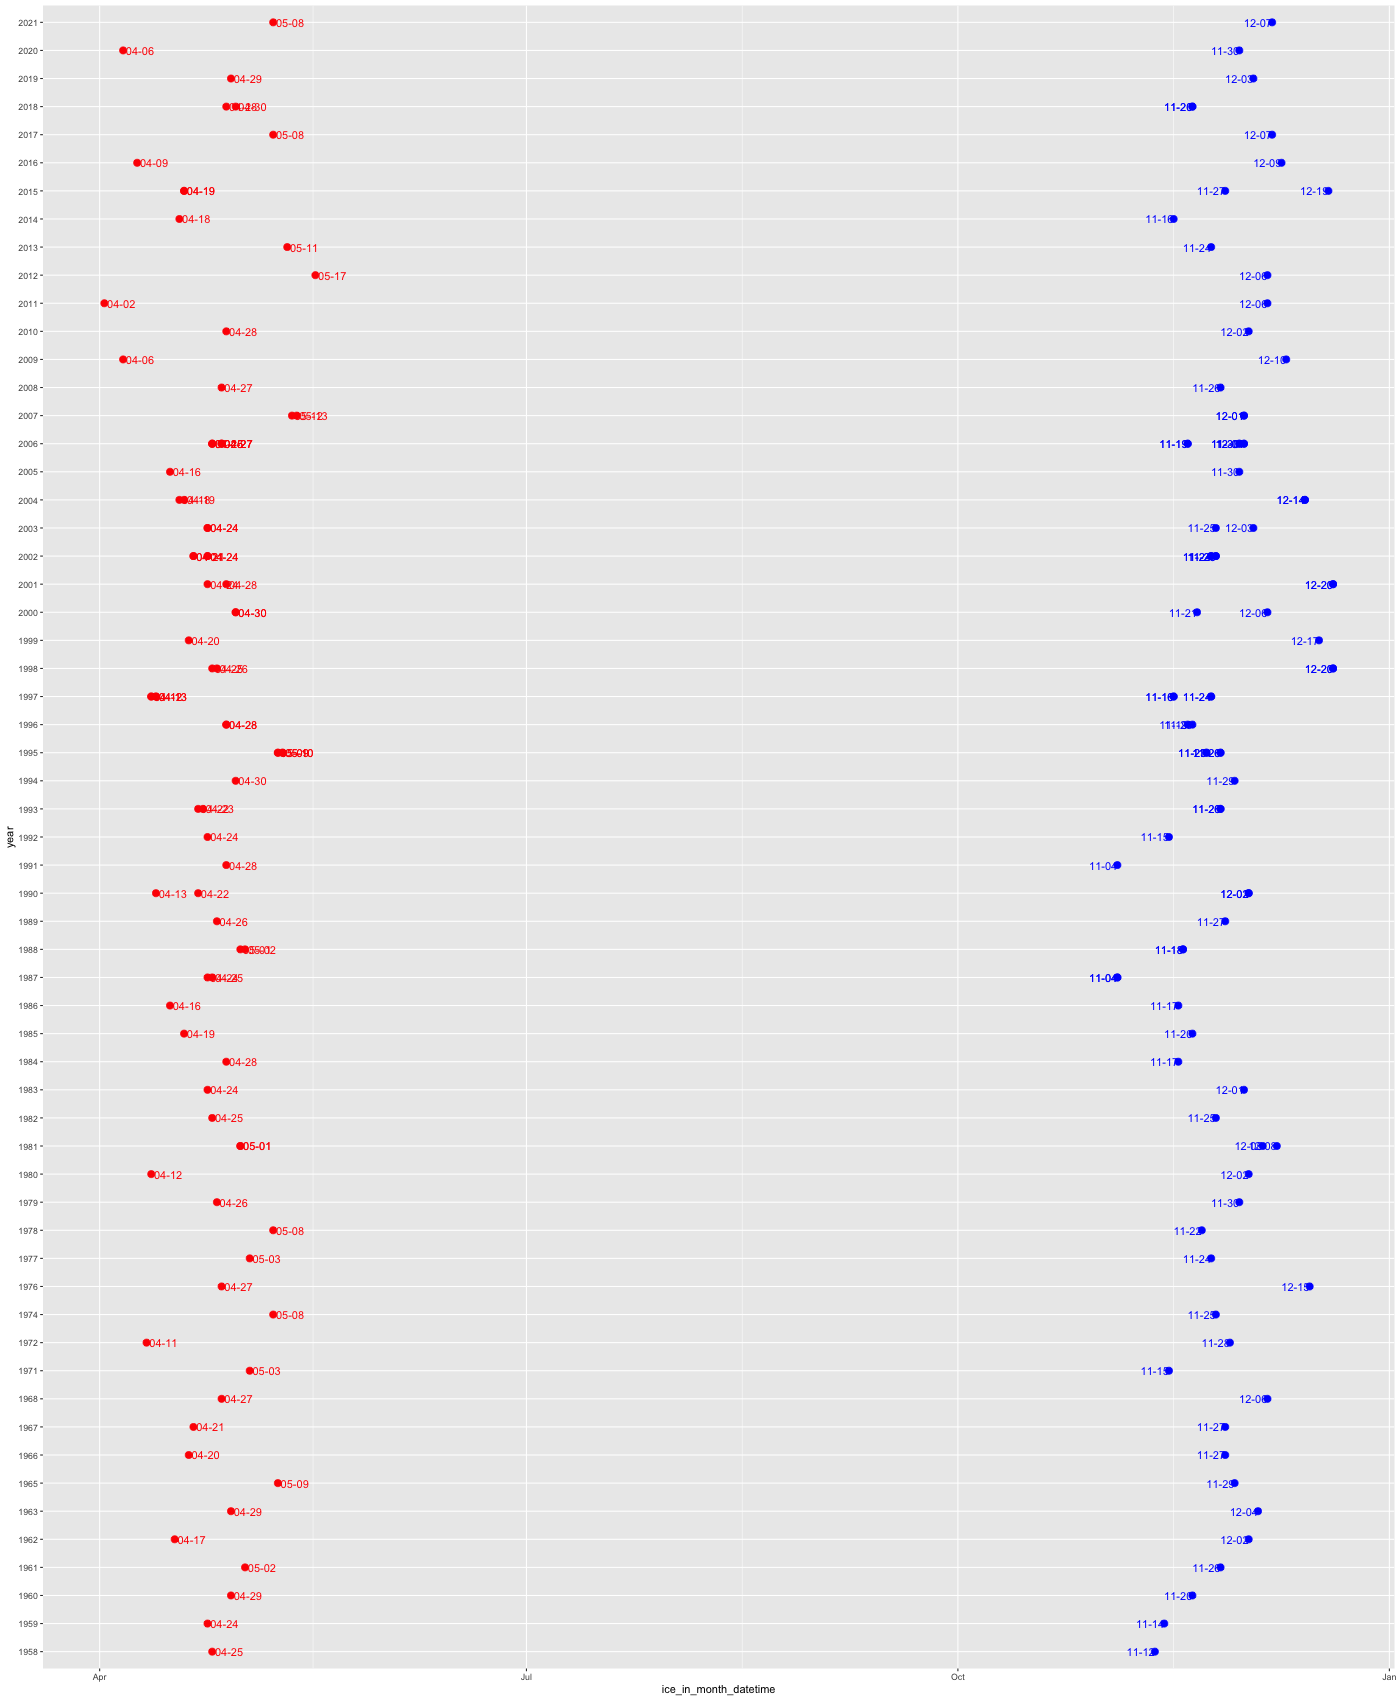

In [996]:
%%R -i bemidji -w 1400 -h 1700

ggplot(bemidji) +
    geom_point(aes(x=ice_in_month_datetime, y = year), size = 3, color='blue') +
    geom_point(aes(x=ice_out_month_datetime, y = year), size = 3, color='red') +
    geom_text(aes(x = ice_in_month_datetime, y = year, label = ice_in_month_day_dt), hjust = 1, nudge_x = 2, color = 'blue') +
    geom_text(aes(x = ice_out_month_datetime, y = year, label = ice_out_month_day_dt), hjust = -0.1, nudge_x = -2, color = 'red')
#     scale_x_date(limits = as.Date(c("1990-06-01", "1990-05-31")))

In [972]:
%%R

library(ggplot2)
library(dplyr)

# convert date-time strings to Date objects
bemidji <- bemidji %>%
  mutate(ice_in_month_day_dt = as.Date(ice_in_month_day_dt),
         ice_out_month_day_dt = as.Date(ice_out_month_day_dt))

ggplot(bemidji) +
  geom_point(aes(x = ice_in_month_day_dt, y = year), size = 3, color = 'blue') +
  geom_point(aes(x = ice_out_month_day_dt, y = year), size = 3, color = 'red') +
  geom_text(aes(x = ice_in_month_day_dt, y = year, label = ice_in_month_day_dt), hjust = 1, nudge_x = 2, color = 'blue') +
  geom_text(aes(x = ice_out_month_day_dt, y = year, label = ice_out_month_day_dt), hjust = -0.1, nudge_x = -2, color = 'red') +
  scale_x_date(date_labels = "%b %d", 
               limits = c(as.Date("2000-06-01"), as.Date("2001-05-31"))) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))







Error in `mutate()`:
! Problem while computing `ice_in_month_day_dt =
  as.Date(ice_in_month_day_dt)`.
Caused by error in `charToDate()`:
! character string is not in a standard unambiguous format
Run `rlang::last_error()` to see where the error occurred.

Error in mutate(., ice_in_month_day_dt = as.Date(ice_in_month_day_dt),  : 
  
Caused by error in `charToDate()`:
! character string is not in a standard unambiguous format


RInterpreterError: Failed to parse and evaluate line '\nlibrary(ggplot2)\nlibrary(dplyr)\n\n# convert date-time strings to Date objects\nbemidji <- bemidji %>%\n  mutate(ice_in_month_day_dt = as.Date(ice_in_month_day_dt),\n         ice_out_month_day_dt = as.Date(ice_out_month_day_dt))\n\nggplot(bemidji) +\n  geom_point(aes(x = ice_in_month_day_dt, y = year), size = 3, color = \'blue\') +\n  geom_point(aes(x = ice_out_month_day_dt, y = year), size = 3, color = \'red\') +\n  geom_text(aes(x = ice_in_month_day_dt, y = year, label = ice_in_month_day_dt), hjust = 1, nudge_x = 2, color = \'blue\') +\n  geom_text(aes(x = ice_out_month_day_dt, y = year, label = ice_out_month_day_dt), hjust = -0.1, nudge_x = -2, color = \'red\') +\n  scale_x_date(date_labels = "%b %d", \n               limits = c(as.Date("2000-06-01"), as.Date("2001-05-31"))) +\n  theme(axis.text.x = element_text(angle = 45, hjust = 1))\n\n\n\n\n\n'.
R error message: 'Error in mutate(., ice_in_month_day_dt = as.Date(ice_in_month_day_dt),  : \n  \nCaused by error in `charToDate()`:\n! character string is not in a standard unambiguous format'

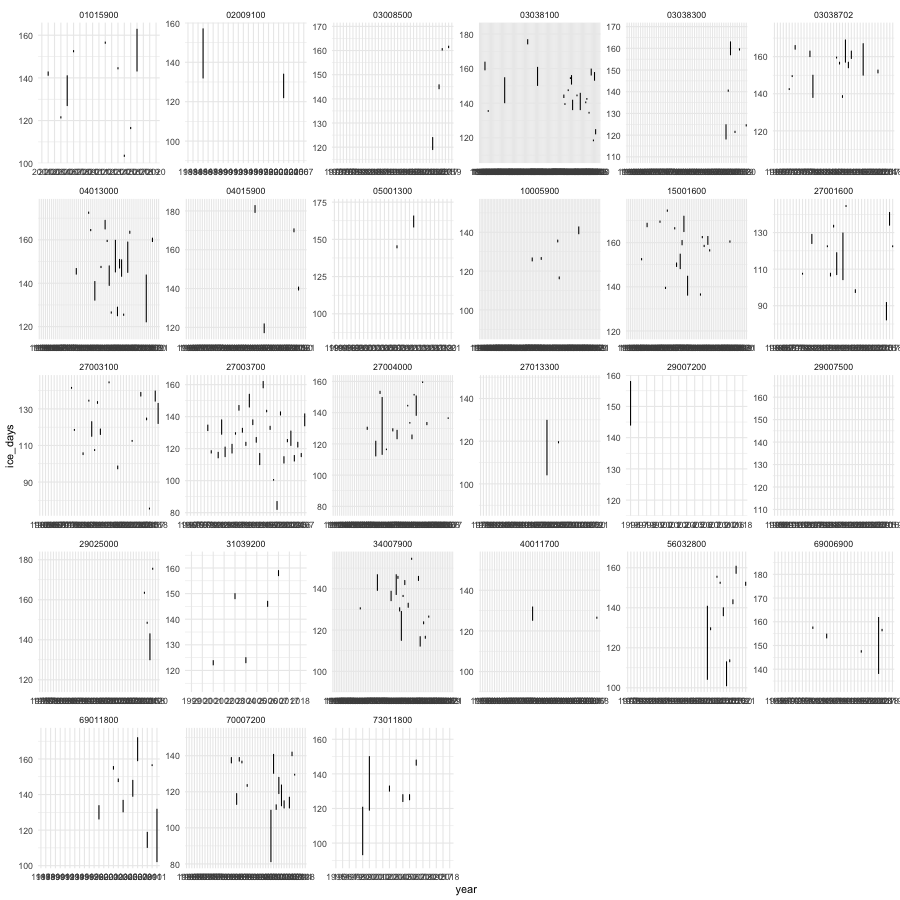

In [647]:
%%R -i df_50plus -w 900 -h 900

ggplot(df_50plus) +
    aes(x=year, y=ice_days) + 
    geom_line() +
    facet_wrap(~lake_id, scales="free") +
    theme_minimal()